# Previsão para Concessão de Empréstimos

Neste projeto, construirei um modelo de **machine learning** para prever a **probabilidade de um empréstimo ser aprovado**. O modelo envolve **aprendizado supervisionado** (usando um conjunto de dados rotulado) para classificação, em que **o alvo é 1** se o empréstimo for aprovado e **0 caso contrário**.


Utilizarei o seguinte **pipeline**, baseado no **framework CRISP-DM**:

1. Definir o problema de negócio.

2. Coletar os dados e obter uma visão geral sobre eles.

3. Dividir os dados em conjuntos de treino e teste.

4. Explorar os dados (análise exploratória de dados – EDA).

5. Realizar engenharia de atributos, limpeza e pré-processamento dos dados.

6. Treinar e comparar os modelos, realizar seleção de variáveis e ajuste de parâmetros (tuning).

7. Testar e avaliar o modelo final em produção.

8. Concluir e interpretar os resultados do modelo.

Neste notebook, realizarei a modelagem de machine learning, correspondendo às etapas 5 a 8 do pipeline apresentado anteriormente. O principal objetivo aqui é construir um modelo capaz de prever com precisão a condição do empréstimo, identificando o risco associado a cada cliente. Com esse modelo, a instituição financeira pode tomar decisões mais assertivas na concessão de crédito, reduzindo perdas e aumentando a eficiência do processo de análise. Conceder empréstimos sem avaliar corretamente o risco pode gerar prejuízos significativos, enquanto uma boa previsão auxilia no controle da carteira de crédito. Ao longo das próximas seções, explicarei cada decisão tomada durante a modelagem, justificando as escolhas de técnicas e procedimentos

## **Imoprtaando bibliotecas**

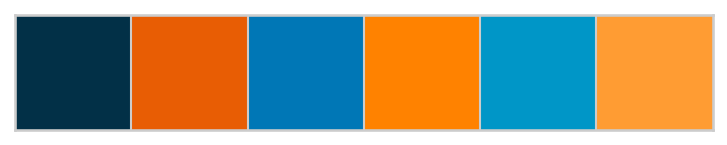

In [27]:
# Manipulação de dados e visualização
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

# Divisão da base
from sklearn.model_selection import train_test_split

from scipy import stats

%matplotlib inline

# Nosso tema
color_palette = ['#023047', '#e85d04', '#0077b6', '#ff8200', '#0096c7', '#ff9c33']

sns.set_theme(
    style="whitegrid",      
    palette=color_palette, 
    font_scale=1.1        
)

plt.rcParams['figure.dpi'] = 150

sns.palplot(color_palette)
plt.show()

## Lendo os Dados

In [ ]:
db = pd.read_csv(r"C:\Users\gusta\Documents\Porjeto DS\databases\loan_final313_mod.csv")
#db = pd.read_csv(r"C:\Users\davic\OneDrive\Documentos\3UnidadeCienciaDados\projeto-unidade-3-concessores-de-emprestimos\databases\loan_final313_mod.csv")
df = db.copy()

In [29]:
df.head()

,id,year,issue_d,final_d,emp_length_int,home_ownership,home_ownership_cat,income_category,annual_inc,income_cat,...,loan_condition_cat,interest_rate,grade,grade_cat,dti,total_pymnt,total_rec_prncp,recoveries,installment,region
0,63398958.0,2015.0,01/11/2015,1122015.0,8.0,NaN,1.0,Low,78000.0,1.0,...,0.0,15.61,D,4.0,25.71,8079.79,8000.00,0.0,279.72,ulster
1,27610673.0,2014.0,01/10/2014,1012016.0,3.0,NaN,1.0,Low,81700.0,1.0,...,0.0,10.15,B,2.0,22.33,10186.50,7984.24,0.0,679.10,leinster
2,49925091.0,2015.0,01/05/2015,1102015.0,10.0,NaN,3.0,Low,78000.0,1.0,...,0.0,7.89,A,1.0,14.12,20360.22,19725.00,0.0,617.11,Northern-Irl
3,28102260.0,2014.0,01/10/2014,1012016.0,9.0,NaN,1.0,Low,35000.0,1.0,...,0.0,15.61,D,4.0,32.07,4227.73,2888.78,0.0,279.72,ulster
4,57324697.0,NaN,01/08/2015,1012016.0,10.0,NaN,1.0,Low,85000.0,1.0,...,0.0,NaN,D,4.0,25.19,6205.36,3868.70,0.0,1247.68,ulster


## Dividindo a base

In [30]:
X = df.drop(columns=['loan_condition_cat'])
y = df['loan_condition_cat'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
print(f'Tamanho do conjunto de preditores de treino: {X_train.shape}.')
print(f'Tamanho do conjunto alvo de treino: {y_train.shape}.')
print(f'Tamanho do conjunto de preditores de teste: {X_test.shape}.')
print(f'Tamanho do conjunto alvo de teste: {y_test.shape}.')

Tamanho do conjunto de preditores de treino: (6400, 29).
Tamanho do conjunto alvo de treino: (6400,).
Tamanho do conjunto de preditores de teste: (1600, 29).
Tamanho do conjunto alvo de teste: (1600,).


## 5. Engenharia de atributos, limpeza e pré-processamento dos dados

In [ ]:
train = pd.concat([X_train, y_train], axis=1)
teste = pd.concat([X_test, y_test], axis=1)

Nesta etapa foi realizado o tratamento de valores ausentes separando as variáveis numéricas e categóricas. Para as variáveis numéricas utilizou-se a imputação pela média, enquanto para as categóricas foi aplicada a imputação pelo valor mais frequente. O processo de ajuste do imputador foi feito somente com os dados de treino e, em seguida, aplicado ao conjunto de teste utilizando os mesmos parâmetros, garantindo consistência entre os conjuntos. As variáveis y não passaram por nenhuma transformação, sendo apenas copiadas para uso posterior.

In [ ]:
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

imputer_num = SimpleImputer(strategy="mean")
imputer_cat = SimpleImputer(strategy="most_frequent")

X_train_num = pd.DataFrame(
    imputer_num.fit_transform(X_train[num_cols]),
    columns=num_cols
)

X_train_cat = pd.DataFrame(
    imputer_cat.fit_transform(X_train[cat_cols]),
    columns=cat_cols
)


X_test_num = pd.DataFrame(
    imputer_num.transform(X_test[num_cols]),
    columns=num_cols
)

X_test_cat = pd.DataFrame(
    imputer_cat.transform(X_test[cat_cols]),
    columns=cat_cols
)

X_train_imputed = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_imputed = pd.concat([X_test_num, X_test_cat], axis=1)

y_train_imputed = y_train.copy()
y_test_imputed = y_test.copy()


In [34]:
X_train_imputed.head()


,id,year,final_d,emp_length_int,home_ownership_cat,annual_inc,income_cat,loan_amount,term_cat,application_type_cat,...,issue_d,home_ownership,income_category,term,application_type,purpose,interest_payments,loan_condition,grade,region
0,1564771.0,2012.0,1052014.0,2.0,1.0,51500.0,1.0,20050.000000,1.0,1.0,...,01/10/2012,RENT,Low,36 months,INDIVIDUAL,credit_card,High,Bad Loan,D,leinster
1,49713578.0,2015.0,1012016.0,0.5,1.0,95000.0,1.0,14719.215551,1.0,1.0,...,01/05/2015,MORTGAGE,Low,36 months,INDIVIDUAL,debt_consolidation,Low,Good Loan,B,Northern-Irl
2,23844415.0,2015.0,1012016.0,10.0,3.0,60000.0,1.0,4000.000000,1.0,1.0,...,01/01/2015,MORTGAGE,Low,36 months,INDIVIDUAL,credit_card,Low,Good Loan,B,leinster
3,20359222.0,2014.0,1012016.0,10.0,3.0,54000.0,1.0,14000.000000,1.0,1.0,...,01/07/2014,MORTGAGE,Low,36 months,INDIVIDUAL,credit_card,Low,Good Loan,B,munster
4,43995615.0,2015.0,1012016.0,1.0,3.0,40000.0,1.0,6000.000000,1.0,1.0,...,01/04/2015,MORTGAGE,Low,36 months,INDIVIDUAL,credit_card,Low,Good Loan,A,munster


Durante o pré-processamento dos dados, primeiro foi separado as variáveis numéricas e categóricas. Para lidar com valores ausentes, foram usados dois imputadores diferentes: a média para colunas numéricas e o valor mais frequente (moda) para colunas categóricas. O imputador foi ajustado apenas com os dados de treino, garantindo que nenhuma informação do teste fosse utilizada indevidamente. Depois, apliquei o mesmo preenchimento ao conjunto de teste usando somente o transform, mantendo a consistência das estatísticas. Por fim, reuni novamente as colunas imputadas e preservei as variáveis-alvo sem modificações.